### Synthethic Data Experiment

The data for this experiment was generated, the code belows will generate the data, and perform a single run of each version (HDPMM, HDPMM Global Only, DPMM, DPMM Seperated, vHDPMM), and evaluation.

Note that the data generation is random, thus different results may appear, however the ranking of how well the methods perform are consistent. Also, this is a single run, so no mean or std.

In [1]:
using LinearAlgebra
using Clustering
using Random

#### Evaluation Functions 

In [17]:
function evaluate_pred_groups(GT,pred)
    NMI = 0.0
    for i=1:length(pred)
        group_nmi = mutualinfo(GT[i], pred[i]; normed =true)
        if isnan(group_nmi)
            group_nmi = 1.0
        end
        NMI += group_nmi
    end
    return NMI / length(pred)   
end


function evaluate_all_results(GT_Global,
        GT_Local,
        pred_HDPMM,
        pred_HDPMM_GLOBAL,
        pred_DPMM,
        pred_DPMM_seperated,
        pred_vHDPMM_global,
        pred_vHDPMM_local,
        pred_sep_vHDPMM_global,
        pred_sep_vHDPMM_local)
    concat_GT_Local = [GT_Local[i] for i=1:length(GT_Local)]
    concat_GT_Local = reduce(vcat,concat_GT_Local)
    HDPMM_NMI = evaluate_pred_groups(GT_Global, pred_HDPMM)
    HDPMM_GLOBAL_NMI = evaluate_pred_groups(GT_Global, pred_HDPMM_GLOBAL) 
    DPMM_NMI = mutualinfo(concat_GT_Local, pred_DPMM; normed =true)
    DPMM_SEP_NMI = evaluate_pred_groups(GT_Local, pred_DPMM_seperated)
    vHDPMM_GLOBAL_NMI = evaluate_pred_groups(GT_Global, pred_vHDPMM_global)
    vHDPMM_LOCAL_NMI = evaluate_pred_groups(GT_Local, pred_vHDPMM_local)
    vHDPMM_SEP_GLOBAL_NMI = evaluate_pred_groups(GT_Global, pred_sep_vHDPMM_global)
    vHDPMM_SEP_LOCAL_NMI = evaluate_pred_groups(GT_Local, pred_sep_vHDPMM_local)
    println("        HDPMM NMI: $HDPMM_NMI \n
        HDPMM Global NMI: $HDPMM_GLOBAL_NMI \n
        DPMM NMI: $DPMM_NMI \n
        DPMM SEPERATED NMI: $DPMM_SEP_NMI\n
        vHDPMM Global NMI: $vHDPMM_GLOBAL_NMI\n
        vHDPMM Local NMI: $vHDPMM_LOCAL_NMI
        vHDPMM Sep Global NMI: $vHDPMM_SEP_GLOBAL_NMI\n
        vHDPMM Sep Local NMI: $vHDPMM_SEP_LOCAL_NMI")
    return HDPMM_NMI, HDPMM_GLOBAL_NMI, DPMM_NMI, DPMM_SEP_NMI, vHDPMM_GLOBAL_NMI, vHDPMM_LOCAL_NMI, vHDPMM_SEP_GLOBAL_NMI, vHDPMM_SEP_LOCAL_NMI
end
    

evaluate_all_results (generic function with 1 method)

In [7]:
using Distributed
addprocs(2)
@everywhere using DPMMSubClusters
cur_dir = pwd()
@everywhere cd("../")
include("hdp_shared_features.jl")

results_stats (generic function with 1 method)

In [8]:
include("gaussian_generator.jl")

generate_grouped_gaussian_from_hdp_group_counts (generic function with 1 method)

In [9]:
function run_methods_and_get_results(data,gprior,lprior,dp_prior,ghdp,gdim)
    #vHDPM
    println("vHDPMM")
    vhdpmm_results = vhdp_fit(data,gdim,100.0,1000.0,100.0,gprior,lprior,50)
    vhdpmm_global = Dict([i=> create_global_labels(vhdpmm_results[1].groups_dict[i]) for i=1:length(data)])
    vhdpmm_local = Dict([i=> vhdpmm_results[1].groups_dict[i].labels for i=1:length(data)])
    #HDP-ALL
    println("HDP-ALL")
    hdp_results = hdp_fit(data,100.0,1000.0,ghdp,50)
    hdp_all_global = Dict([i=> create_global_labels(hdp_results[1].groups_dict[i]) for i=1:length(data)])
    #HDP-GLOBAL
    println("HDP-GLOBAL")
    global_pts = Dict([k=>v[1:gdim,:] for (k,v) in data])
    hdp_global_results = hdp_fit(global_pts,100.0,1000.0,gprior,50)
    hdp_global_global = Dict([i=> create_global_labels(hdp_global_results[1].groups_dict[i]) for i=1:length(data)])
    #DPMM-All
    println("DPMM-ALL")
    all_data = [data[i] for i=1:length(data)]
    all_data = reduce(hcat,all_data)
    dpmm_all_results = DPMMSubClusters.fit(all_data,dp_prior,100.0,iters = 100, verbose = false)
    dpmm_all_local = dpmm_all_results[1]
    #DPMM-Seperated
    println("DPMM-SEP")
    dpmm_seperated_results = [DPMMSubClusters.fit(data[i],dp_prior,100.0,iters = 100, verbose = false) for i=1:length(data)]
    dpmm_seperated_local = [dpmm_seperated_results[i][1] for i=1:length(data)]
    println("vHDPMM-SEP")
    #vHDPM-Seperated
    vhdpmm_results = [vhdp_fit(Dict([1=>data[i]]),gdim,100.0,1000.0,100.0,gprior,lprior,50) for i=1:length(data)]
    vhdpmm_sep_global = Dict([i=> create_global_labels(vhdpmm_results[i][1].groups_dict[1]) for i=1:length(data)])
    vhdpmm_sep_local = Dict([i=> vhdpmm_results[i][1].groups_dict[1].labels for i=1:length(data)])
#     return vhdpmm_results
    return hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local,vhdpmm_sep_global,vhdpmm_sep_local
end

run_methods_and_get_results (generic function with 1 method)

### G3/2/5/1

In [10]:
pts,labels = generate_grouped_gaussian_data(20000, 2, 1, 3, 5, 10, false, 25.0, false)
labels_global  = Dict([k=> Int.(v[:,1][:]) for (k,v) in labels])
labels_local  = Dict([k=> Int.(v[:,2][:]) for (k,v) in labels])
g_prior, l_prior = create_default_priors(2,1,:niw)
g_hdp, _ = create_default_priors(3,0,:niw)
dp_prior = DPMMSubClusters.niw_hyperparams(1.0,
            zeros(3),
            6,
            Matrix{Float64}(I, 3, 3)*1)

┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = Dirichlet{Float64}(::Array{Float64,1}) at dirichlet.jl:36
└ @ Distributions /home/dinari/.julia/packages/Distributions/0Wogo/src/multivariate/dirichlet.jl:36
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = Dirichlet{Float64}(::Array{Float64,1}) at dirichlet.jl:38
└ @ Distributions /home/dinari/.julia/packages/Distributions/0Wogo/src/multivariate/dirichlet.jl:38


DPMMSubClusters.niw_hyperparams(1.0f0, Float32[0.0, 0.0, 0.0], 6.0f0, Float32[1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0])

In [11]:
hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local,vhdpmm_sep_global, vhdpmm_sep_local =
    run_methods_and_get_results(pts,g_prior,l_prior,dp_prior,g_hdp,2)

vHDPMM


┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = Dirichlet{Float64}(::Array{Float64,1}) at dirichlet.jl:36
└ @ Distributions ~/.julia/packages/Distributions/0Wogo/src/multivariate/dirichlet.jl:36
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = Dirichlet{Float64}(::Array{Float64,1}) at dirichlet.jl:38
└ @ Distributions ~/.julia/packages/Distributions/0Wogo/src/multivariate/dirichlet.jl:38
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = Dirichlet{Float64}(::Array{Float64,1}) at dirichlet.jl:36
└ @ Distributions ~/.julia/packages/Distributions/0Wogo/src/multivariate/dirichlet.jl:36
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = Dirichlet{Float64}(::Array{Float64,1}) at dirichlet.jl:38
└ @ Distributions ~/.julia/packages/Distributions/0Wogo/src/multivariate/dirichlet.jl:38


Iteration: 1|| Global Counts: [10]|| iter time: 14.752573013305664
Iteration: 2|| Global Counts: [10]|| iter time: 0.09416699409484863
Iteration: 3|| Global Counts: [10]|| iter time: 0.11293792724609375
Iteration: 4|| Global Counts: [10]|| iter time: 0.08512306213378906
Iteration: 5|| Global Counts: [10, 10]|| iter time: 0.8287091255187988
Iteration: 6|| Global Counts: [12, 9]|| iter time: 0.5739490985870361
Iteration: 7|| Global Counts: [14, 9]|| iter time: 0.6035599708557129
Iteration: 8|| Global Counts: [14, 12]|| iter time: 0.15747499465942383
Iteration: 9|| Global Counts: [15, 13]|| iter time: 0.11256790161132812
Iteration: 10|| Global Counts: [16, 14, 16]|| iter time: 0.13096904754638672
Iteration: 11|| Global Counts: [17, 15, 15]|| iter time: 0.19583415985107422
Iteration: 12|| Global Counts: [19, 15, 14]|| iter time: 0.28160905838012695
Iteration: 13|| Global Counts: [19, 15, 13]|| iter time: 0.14020919799804688
Iteration: 14|| Global Counts: [19, 15, 13]|| iter time: 0.2773909

Iteration: 8|| Global Counts: [11, 9]|| iter time: 0.09946584701538086
Iteration: 9|| Global Counts: [11, 9]|| iter time: 0.09463095664978027
Iteration: 10|| Global Counts: [11, 9]|| iter time: 0.09450078010559082
Iteration: 11|| Global Counts: [11, 9]|| iter time: 0.09900903701782227
Iteration: 12|| Global Counts: [11, 9]|| iter time: 0.09628987312316895
Iteration: 13|| Global Counts: [11, 9]|| iter time: 0.0945580005645752
Iteration: 14|| Global Counts: [11, 9]|| iter time: 0.09570097923278809
Iteration: 15|| Global Counts: [11, 9, 11]|| iter time: 0.10434889793395996
Iteration: 16|| Global Counts: [12, 9, 10]|| iter time: 0.10990309715270996
Iteration: 17|| Global Counts: [12, 9, 10]|| iter time: 0.10413384437561035
Iteration: 18|| Global Counts: [13, 9, 10]|| iter time: 0.11100912094116211
Iteration: 19|| Global Counts: [14, 9, 10]|| iter time: 0.11140012741088867
Iteration: 20|| Global Counts: [12, 9, 10]|| iter time: 0.10510802268981934
Iteration: 21|| Global Counts: [11, 9, 10]|

Iteration: 23|| Global Counts: [2, 3, 1]|| iter time: 0.029513835906982422
Iteration: 24|| Global Counts: [2, 3, 1]|| iter time: 0.02486395835876465
Iteration: 25|| Global Counts: [2, 3, 1]|| iter time: 0.027283191680908203
Iteration: 26|| Global Counts: [2, 3, 1]|| iter time: 0.02750110626220703
Iteration: 27|| Global Counts: [2, 3, 1]|| iter time: 0.024854183197021484
Iteration: 28|| Global Counts: [2, 3, 1]|| iter time: 0.026978015899658203
Iteration: 29|| Global Counts: [2, 3, 1]|| iter time: 0.028334856033325195
Iteration: 30|| Global Counts: [2, 3, 1]|| iter time: 0.02788090705871582
Iteration: 31|| Global Counts: [2, 3, 1]|| iter time: 0.026278018951416016
Iteration: 32|| Global Counts: [2, 3, 1]|| iter time: 0.02300715446472168
Iteration: 33|| Global Counts: [2, 3, 1]|| iter time: 0.027051925659179688
Iteration: 34|| Global Counts: [2, 3, 1]|| iter time: 0.02791309356689453
Iteration: 35|| Global Counts: [2, 3, 1]|| iter time: 0.023877859115600586
Iteration: 36|| Global Counts:

Iteration: 37|| Global Counts: [2, 2, 1]|| iter time: 0.028104066848754883
Iteration: 38|| Global Counts: [2, 2, 1]|| iter time: 0.023652076721191406
Iteration: 39|| Global Counts: [2, 2, 1]|| iter time: 0.025441884994506836
Iteration: 40|| Global Counts: [2, 2, 1]|| iter time: 0.02503800392150879
Iteration: 41|| Global Counts: [2, 2, 1]|| iter time: 0.023988008499145508
Iteration: 42|| Global Counts: [2, 2, 1]|| iter time: 0.025330066680908203
Iteration: 43|| Global Counts: [2, 2, 1]|| iter time: 0.021676063537597656
Iteration: 44|| Global Counts: [2, 2, 1]|| iter time: 0.025700092315673828
Iteration: 45|| Global Counts: [2, 2, 1]|| iter time: 0.023307085037231445
Iteration: 46|| Global Counts: [2, 2, 1]|| iter time: 0.025734901428222656
Iteration: 47|| Global Counts: [2, 2, 1]|| iter time: 0.02612018585205078
Iteration: 48|| Global Counts: [2, 2, 1]|| iter time: 0.026964187622070312
Iteration: 49|| Global Counts: [2, 2, 1]|| iter time: 0.027887821197509766
Iteration: 50|| Global Coun

Iteration: 6|| Global Counts: [1]|| iter time: 0.014044046401977539
Iteration: 7|| Global Counts: [1]|| iter time: 0.021111011505126953
Iteration: 8|| Global Counts: [1]|| iter time: 0.014178037643432617
Iteration: 9|| Global Counts: [1, 1]|| iter time: 0.014955997467041016
Iteration: 10|| Global Counts: [1, 1]|| iter time: 0.02024221420288086
Iteration: 11|| Global Counts: [1, 1]|| iter time: 0.015455961227416992
Iteration: 12|| Global Counts: [2, 2]|| iter time: 0.02349400520324707
Iteration: 13|| Global Counts: [2, 2]|| iter time: 0.021397829055786133
Iteration: 14|| Global Counts: [2, 2]|| iter time: 0.019563913345336914
Iteration: 15|| Global Counts: [2, 2]|| iter time: 0.023088932037353516
Iteration: 16|| Global Counts: [2, 2]|| iter time: 0.019881010055541992
Iteration: 17|| Global Counts: [2, 2, 2]|| iter time: 0.026968955993652344
Iteration: 18|| Global Counts: [2, 2, 2]|| iter time: 0.02684497833251953
Iteration: 19|| Global Counts: [2, 2, 2]|| iter time: 0.02367997169494629


Iteration: 20|| Global Counts: [2, 6, 2]|| iter time: 0.03431296348571777
Iteration: 21|| Global Counts: [2, 9, 2]|| iter time: 0.037077903747558594
Iteration: 22|| Global Counts: [2, 10, 2]|| iter time: 0.03826594352722168
Iteration: 23|| Global Counts: [2, 12, 2]|| iter time: 0.04452991485595703
Iteration: 24|| Global Counts: [2, 11, 2]|| iter time: 0.04488205909729004
Iteration: 25|| Global Counts: [2, 13, 2]|| iter time: 0.051177024841308594
Iteration: 26|| Global Counts: [2, 12, 2]|| iter time: 0.04641008377075195
Iteration: 27|| Global Counts: [2, 12, 2]|| iter time: 0.047914981842041016
Iteration: 28|| Global Counts: [2, 13, 2]|| iter time: 0.0492711067199707
Iteration: 29|| Global Counts: [2, 15, 2]|| iter time: 0.050299882888793945
Iteration: 30|| Global Counts: [2, 15, 3]|| iter time: 0.1027679443359375
Iteration: 31|| Global Counts: [2, 12, 3]|| iter time: 0.052674055099487305
Iteration: 32|| Global Counts: [2, 12, 2]|| iter time: 0.04899311065673828
Iteration: 33|| Global C

(Dict(7 => [1; 1; … ; 4; 4],4 => [1; 1; … ; 3; 3],9 => [7; 7; … ; 1; 1],10 => [3; 3; … ; 3; 3],2 => [1; 1; … ; 3; 3],3 => [1; 1; … ; 1; 1],5 => [4; 4; … ; 6; 6],8 => [1; 1; … ; 5; 5],6 => [8; 6; … ; 3; 3],1 => [1; 1; … ; 1; 1]…), Dict(7 => [2; 2; … ; 3; 3],4 => [2; 2; … ; 1; 1],9 => [1; 1; … ; 2; 2],10 => [1; 1; … ; 1; 1],2 => [2; 2; … ; 1; 1],3 => [2; 2; … ; 2; 2],5 => [3; 3; … ; 1; 1],8 => [2; 2; … ; 1; 1],6 => [1; 1; … ; 1; 1],1 => [2; 2; … ; 2; 2]…), [2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  4, 4, 4, 4, 4, 4, 4, 4, 4, 4], Array{Int64,1}[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4  …  3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3  …  5, 5, 5, 5, 5, 5, 5, 5, 5, 5], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  2, 3, 3, 3, 3, 3, 3, 3, 3, 3], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1,

In [18]:
evaluate_all_results(labels_global,labels_local,hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local,vhdpmm_sep_global, vhdpmm_sep_local)

        HDPMM NMI: 0.8601931917950649 

        HDPMM Global NMI: 0.9955555260567015 

        DPMM NMI: 0.11011280785630909 

        DPMM SEPERATED NMI: 0.8137679933231299

        vHDPMM Global NMI: 0.998575987389741

        vHDPMM Local NMI: 0.8971439488393658
        vHDPMM Sep Global NMI: 0.9866739061997134

        vHDPMM Sep Local NMI: 0.857428892855844


(0.8601931917950649, 0.9955555260567015, 0.11011280785630909, 0.8137679933231299, 0.998575987389741, 0.8971439488393658, 0.9866739061997134, 0.857428892855844)

### G/5/2/10/1

In [45]:
pts,labels = generate_grouped_gaussian_data(20000, 2, 1, 5, 10, 10, false, 25.0, false)
labels_global  = Dict([k=> Int.(v[:,1][:]) for (k,v) in labels])
labels_local  = Dict([k=> Int.(v[:,2][:]) for (k,v) in labels])
g_prior, l_prior = create_default_priors(2,1,:niw)
g_hdp, _ = create_default_priors(3,0,:niw)
dp_prior = DPMMSubClusters.niw_hyperparams(1.0,
            zeros(3),
            6,
            Matrix{Float64}(I, 3, 3)*1)

DPMMSubClusters.niw_hyperparams(1.0f0, Float32[0.0, 0.0, 0.0], 6.0f0, Float32[1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0])

In [50]:
hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local,vhdpmm_sep_global, vhdpmm_sep_local =
    run_methods_and_get_results(pts,g_prior,l_prior,dp_prior,g_hdp,2)

Iteration: 1|| Global Counts: [10]|| iter time: 0.07932209968566895
Iteration: 2|| Global Counts: [10]|| iter time: 0.06276988983154297
Iteration: 3|| Global Counts: [10]|| iter time: 0.0638270378112793
Iteration: 4|| Global Counts: [10]|| iter time: 0.06200885772705078
Iteration: 5|| Global Counts: [10]|| iter time: 0.06989693641662598
Iteration: 6|| Global Counts: [11]|| iter time: 0.06776189804077148
Iteration: 7|| Global Counts: [12]|| iter time: 0.05917191505432129
Iteration: 8|| Global Counts: [13, 13]|| iter time: 0.07440185546875
Iteration: 9|| Global Counts: [13, 14]|| iter time: 0.07931900024414062
Iteration: 10|| Global Counts: [14, 15]|| iter time: 0.10039091110229492
Iteration: 11|| Global Counts: [14, 15]|| iter time: 0.10526490211486816
Iteration: 12|| Global Counts: [14, 15]|| iter time: 0.0866708755493164
Iteration: 13|| Global Counts: [14, 15]|| iter time: 0.10084891319274902
Iteration: 14|| Global Counts: [14, 15]|| iter time: 0.08404397964477539
Iteration: 15|| Glob

(Dict(7 => [1; 1; … ; 1; 1],4 => [1; 1; … ; 3; 3],9 => [2; 2; … ; 2; 2],10 => [1; 1; … ; 1; 1],2 => [1; 1; … ; 1; 1],3 => [1; 3; … ; 1; 1],5 => [2; 2; … ; 2; 2],8 => [1; 1; … ; 1; 1],6 => [1; 1; … ; 2; 2],1 => [1; 1; … ; 2; 2]…), Dict(7 => [4; 4; … ; 4; 4],4 => [4; 3; … ; 3; 3],9 => [1; 4; … ; 1; 1],10 => [4; 4; … ; 4; 2],2 => [4; 4; … ; 2; 2],3 => [4; 4; … ; 4; 4],5 => [1; 1; … ; 1; 1],8 => [4; 2; … ; 2; 4],6 => [2; 2; … ; 1; 1],1 => [4; 4; … ; 1; 1]…), [4, 4, 4, 4, 4, 4, 4, 4, 4, 4  …  4, 4, 4, 4, 4, 4, 4, 4, 4, 4], Array{Int64,1}[[5, 5, 5, 5, 5, 5, 5, 5, 5, 5  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [5, 5, 5, 5, 5, 5, 5, 5, 5, 5  …  6, 6, 6, 6, 6, 6, 6, 6, 6, 6], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [6, 6, 6, 6, 6, 6, 6, 6, 6, 6  …  3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4  …  5, 5, 5, 5, 5, 5, 5, 5, 5, 3], [2, 2,

In [49]:
evaluate_all_results(labels_global,labels_local,hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local,vhdpmm_sep_global, vhdpmm_sep_local)

        HDPMM NMI: 0.5962808377038267 

        HDPMM Global NMI: 0.5230217504385959 

        DPMM NMI: 0.09201440768574354 

        DPMM SEPERATED NMI: 0.7807007607296851

        vHDPMM Global NMI: 0.8575736257627968

        vHDPMM Local NMI: 0.769173722643137
        vHDPMM Sep Global NMI: 0.9574726882036986

        vHDPMM Sep Local NMI: 0.8415105135227854


### G3/5/5/5

In [94]:
pts,labels = generate_grouped_gaussian_data(20000, 5, 5, 3, 5, 10, false, 5.0, false)
labels_global  = Dict([k=> Int.(v[:,1][:]) for (k,v) in labels])
labels_local  = Dict([k=> Int.(v[:,2][:]) for (k,v) in labels])
g_prior, l_prior = create_default_priors(5,5,:niw)
g_hdp, _ = create_default_priors(10,0,:niw)
dp_prior = DPMMSubClusters.niw_hyperparams(1.0,
            zeros(10),
            13,
            Matrix{Float64}(I, 10, 10)*1)

DPMMSubClusters.niw_hyperparams(1.0f0, Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 13.0f0, Float32[1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0])

In [98]:
hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local =
    run_methods_and_get_results(pts,g_prior,l_prior,dp_prior,g_hdp,5)

Iteration: 1|| Global Counts: [10]|| iter time: 0.09925484657287598
Iteration: 2|| Global Counts: [10]|| iter time: 0.08538007736206055
Iteration: 3|| Global Counts: [14]|| iter time: 0.0917508602142334
Iteration: 4|| Global Counts: [19]|| iter time: 0.0998380184173584
Iteration: 5|| Global Counts: [20, 20]|| iter time: 0.13539600372314453
Iteration: 6|| Global Counts: [20, 22]|| iter time: 0.12878894805908203
Iteration: 7|| Global Counts: [17, 25]|| iter time: 0.17097210884094238
Iteration: 8|| Global Counts: [19, 29]|| iter time: 0.1337568759918213
Iteration: 9|| Global Counts: [20, 32]|| iter time: 0.13122200965881348
Iteration: 10|| Global Counts: [20, 33, 20]|| iter time: 0.1511249542236328
Iteration: 11|| Global Counts: [18, 34, 20]|| iter time: 0.1815948486328125
Iteration: 12|| Global Counts: [19, 35, 21]|| iter time: 0.1531200408935547
Iteration: 13|| Global Counts: [19, 36, 18]|| iter time: 0.17380094528198242
Iteration: 14|| Global Counts: [21, 38, 5]|| iter time: 0.15140604

(Dict(7 => [1; 1; … ; 13; 13],4 => [30; 30; … ; 52; 52],9 => [15; 15; … ; 56; 56],10 => [6; 6; … ; 48; 48],2 => [22; 22; … ; 45; 45],3 => [40; 40; … ; 14; 14],5 => [33; 33; … ; 5; 5],8 => [8; 8; … ; 17; 32],6 => [39; 39; … ; 49; 49],1 => [20; 20; … ; 10; 10]…), Dict(7 => [2; 2; … ; 4; 4],4 => [4; 1; … ; 4; 4],9 => [4; 4; … ; 4; 4],10 => [2; 2; … ; 4; 1],2 => [2; 2; … ; 4; 4],3 => [4; 4; … ; 4; 4],5 => [4; 4; … ; 2; 2],8 => [4; 4; … ; 2; 2],6 => [4; 4; … ; 4; 4],1 => [2; 2; … ; 3; 3]…), [5, 5, 5, 5, 5, 5, 5, 5, 5, 5  …  15, 15, 15, 15, 15, 15, 15, 15, 15, 15], Array{Int64,1}[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3  …  5, 5, 5, 5, 5, 5, 5, 5, 5, 5], [5, 5, 5, 5, 5, 5, 5, 5, 5, 5  …  3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [5, 5, 5, 5, 5, 5, 5, 5, 5, 5

In [99]:
evaluate_all_results(labels_global,labels_local,hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local)

        HDPMM NMI: 0.4678883301176849 

        HDPMM Global NMI: 0.6744278586669658 

        DPMM NMI: 0.2566984566730755 

        DPMM SEPERATED NMI: 0.9957817663148015

        vHDPMM Global NMI: 1.0

        vHDPMM Local NMI: 0.9468667987041288


### G5/5/10/5

In [103]:
pts,labels = generate_grouped_gaussian_data(20000, 5, 5, 5, 10, 10, false, 3.0, false)
labels_global  = Dict([k=> Int.(v[:,1][:]) for (k,v) in labels])
labels_local  = Dict([k=> Int.(v[:,2][:]) for (k,v) in labels])
g_prior, l_prior = create_default_priors(5,5,:niw)
g_hdp, _ = create_default_priors(10,0,:niw)
dp_prior = DPMMSubClusters.niw_hyperparams(1.0,
            zeros(10),
            13,
            Matrix{Float64}(I, 10, 10)*1)

DPMMSubClusters.niw_hyperparams(1.0f0, Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 13.0f0, Float32[1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0])

In [104]:
hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local =
    run_methods_and_get_results(pts,g_prior,l_prior,dp_prior,g_hdp,5)

Iteration: 1|| Global Counts: [10]|| iter time: 0.08164691925048828
Iteration: 2|| Global Counts: [10]|| iter time: 0.08995819091796875
Iteration: 3|| Global Counts: [13]|| iter time: 0.08299922943115234
Iteration: 4|| Global Counts: [19]|| iter time: 0.09338593482971191
Iteration: 5|| Global Counts: [20, 20]|| iter time: 0.11852097511291504
Iteration: 6|| Global Counts: [21, 21]|| iter time: 0.11942195892333984
Iteration: 7|| Global Counts: [25, 25]|| iter time: 0.14038395881652832
Iteration: 8|| Global Counts: [29, 32]|| iter time: 0.12276411056518555
Iteration: 9|| Global Counts: [34, 34]|| iter time: 0.20136404037475586
Iteration: 10|| Global Counts: [37, 38, 37, 38]|| iter time: 0.15508699417114258
Iteration: 11|| Global Counts: [34, 33, 45, 43]|| iter time: 0.2708289623260498
Iteration: 12|| Global Counts: [32, 36, 49, 42]|| iter time: 0.23958492279052734
Iteration: 13|| Global Counts: [34, 35, 49, 43]|| iter time: 0.2400209903717041
Iteration: 14|| Global Counts: [35, 35, 39, 45

(Dict(7 => [68; 68; … ; 80; 80],4 => [23; 23; … ; 84; 37],9 => [25; 25; … ; 50; 50],10 => [14; 14; … ; 85; 85],2 => [42; 42; … ; 33; 33],3 => [17; 17; … ; 35; 35],5 => [86; 86; … ; 15; 15],8 => [62; 62; … ; 59; 59],6 => [58; 99; … ; 82; 82],1 => [76; 76; … ; 81; 81]…), Dict(7 => [7; 10; … ; 6; 6],4 => [4; 4; … ; 7; 6],9 => [6; 7; … ; 2; 8],10 => [4; 4; … ; 4; 4],2 => [6; 6; … ; 8; 2],3 => [6; 6; … ; 8; 8],5 => [4; 4; … ; 3; 3],8 => [4; 4; … ; 5; 7],6 => [4; 4; … ; 4; 4],1 => [4; 4; … ; 3; 3]…), [3, 3, 3, 3, 3, 3, 3, 3, 3, 3  …  3, 3, 3, 3, 3, 3, 3, 3, 3, 3], Array{Int64,1}[[9, 9, 9, 9, 9, 9, 9, 9, 9, 9  …  7, 7, 7, 7, 7, 7, 7, 7, 7, 7], [5, 5, 5, 5, 5, 5, 5, 5, 5, 5  …  4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3  …  7, 7, 7, 7, 7, 7, 7, 7, 7, 7], [10, 10, 10, 10, 10, 10, 10, 10, 10, 10  …  3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [6, 6, 6, 6, 6, 6, 6, 6, 6, 6  …  7, 7, 7, 7, 7, 7, 7, 7, 7, 7], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [6, 6, 6, 6, 6, 6, 6

In [ ]:
hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local =
    run_methods_and_get_results(pts,g_prior,l_prior,dp_prior,g_hdp,5)

In [102]:
evaluate_all_results(labels_global,labels_local,hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local)

        HDPMM NMI: 0.5974369777334086 

        HDPMM Global NMI: 1.0 

        DPMM NMI: 0.20499041041418847 

        DPMM SEPERATED NMI: 0.9867872394833215

        vHDPMM Global NMI: 1.0

        vHDPMM Local NMI: 0.919179221284163


### M10/5/20/5

In [106]:
pts,labels = generate_grouped_mnm_data(20000, 5, 5, 10, 20, 10, false, 100)
labels_global  = Dict([k=> Int.(v[:,1][:]) for (k,v) in labels])
labels_local  = Dict([k=> Int.(v[:,2][:]) for (k,v) in labels])
g_prior, l_prior = create_default_priors(5,5,:mnm)
g_hdp, _ = create_default_priors(10,0,:mnm)
dp_prior = DPMMSubClusters.multinomial_hyper(ones(10))

DPMMSubClusters.multinomial_hyper(Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [107]:
hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local =
    run_methods_and_get_results(pts,g_prior,l_prior,dp_prior,g_hdp,5)

Iteration: 1|| Global Counts: [15]|| iter time: 1.2652862071990967
Iteration: 2|| Global Counts: [20]|| iter time: 0.08173108100891113
Iteration: 3|| Global Counts: [30]|| iter time: 0.06968092918395996
Iteration: 4|| Global Counts: [39]|| iter time: 0.08442902565002441
Iteration: 5|| Global Counts: [57, 57]|| iter time: 0.1009669303894043
Iteration: 6|| Global Counts: [68, 64]|| iter time: 0.15668296813964844
Iteration: 7|| Global Counts: [83, 62]|| iter time: 0.1469709873199463
Iteration: 8|| Global Counts: [93, 62]|| iter time: 0.16865301132202148
Iteration: 9|| Global Counts: [96, 60]|| iter time: 0.16489100456237793
Iteration: 10|| Global Counts: [99, 60, 99, 60]|| iter time: 0.18330979347229004
Iteration: 11|| Global Counts: [95, 65, 88, 46]|| iter time: 0.25973081588745117
Iteration: 12|| Global Counts: [84, 48, 64, 25]|| iter time: 0.24779009819030762
Iteration: 13|| Global Counts: [88, 47, 25, 21]|| iter time: 0.17995285987854004
Iteration: 14|| Global Counts: [85, 47, 21, 21]

(Dict(7 => [40; 40; … ; 93; 93],4 => [41; 41; … ; 41; 41],9 => [91; 91; … ; 52; 52],10 => [46; 46; … ; 2; 2],2 => [59; 59; … ; 41; 41],3 => [31; 31; … ; 35; 35],5 => [10; 10; … ; 47; 47],8 => [63; 63; … ; 11; 11],6 => [66; 66; … ; 105; 105],1 => [5; 5; … ; 45; 45]…), Dict(7 => [2; 2; … ; 3; 3],4 => [3; 3; … ; 8; 3],9 => [2; 2; … ; 3; 3],10 => [3; 3; … ; 3; 3],2 => [4; 4; … ; 3; 3],3 => [2; 2; … ; 8; 8],5 => [3; 3; … ; 4; 4],8 => [4; 4; … ; 3; 3],6 => [1; 1; … ; 5; 5],1 => [3; 3; … ; 2; 2]…), [10, 10, 10, 10, 10, 10, 10, 10, 10, 10  …  9, 9, 9, 9, 9, 9, 9, 9, 9, 9], Array{Int64,1}[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3  …  14, 14, 14, 14, 14, 14, 14, 14, 14, 14], [5, 5, 5, 5, 5, 5, 5, 5, 5, 5  …  15, 15, 15, 15, 15, 15, 15, 15, 15, 15], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3  …  11, 11, 11, 11, 11, 11, 11, 11, 11, 11], [11, 11, 11, 11, 11, 11, 11, 11, 11, 11  …  11, 11, 11, 11, 11, 11, 11, 11, 11, 11], [10, 10, 10, 10, 10, 10, 10, 10, 10, 10  …  6, 6, 6, 6, 6, 6, 6, 6, 6, 6], [14, 14, 14, 14, 14, 14, 14,

In [108]:
evaluate_all_results(labels_global,labels_local,hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local)

        HDPMM NMI: 0.704152567569414 

        HDPMM Global NMI: 0.8916035123151156 

        DPMM NMI: 0.2603007055814523 

        DPMM SEPERATED NMI: 0.9261702914785271

        vHDPMM Global NMI: 0.98953733155964

        vHDPMM Local NMI: 0.9755482398171627


### M10/200/20/200

This can be very memory intensive!

In [6]:
pts,labels = generate_grouped_mnm_data(20000, 200, 200, 10, 20, 10, false, 100)
labels_global  = Dict([k=> Int.(v[:,1][:]) for (k,v) in labels])
labels_local  = Dict([k=> Int.(v[:,2][:]) for (k,v) in labels])
g_prior, l_prior = create_default_priors(200,200,:mnm)
g_hdp, _ = create_default_priors(400,0,:mnm)
dp_prior = DPMMSubClusters.multinomial_hyper(ones(400))

DPMMSubClusters.multinomial_hyper(Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [7]:
hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local =
    run_methods_and_get_results(pts,g_prior,l_prior,dp_prior,g_hdp,200)

Iteration: 1|| Global Counts: [10]|| iter time: 11.340212106704712
Iteration: 2|| Global Counts: [14]|| iter time: 1.1411809921264648
Iteration: 3|| Global Counts: [20]|| iter time: 0.8548691272735596
Iteration: 4|| Global Counts: [21]|| iter time: 0.6994519233703613
Iteration: 5|| Global Counts: [29, 29]|| iter time: 1.334416151046753
Iteration: 6|| Global Counts: [33, 40]|| iter time: 1.0469541549682617
Iteration: 7|| Global Counts: [34, 50]|| iter time: 1.0252420902252197
Iteration: 8|| Global Counts: [42, 71]|| iter time: 0.9239120483398438
Iteration: 9|| Global Counts: [44, 88]|| iter time: 0.9990200996398926
Iteration: 10|| Global Counts: [47, 103, 47, 103]|| iter time: 1.1050560474395752
Iteration: 11|| Global Counts: [44, 67, 11, 80]|| iter time: 1.6803770065307617
Iteration: 12|| Global Counts: [45, 70, 8, 74]|| iter time: 1.380774974822998
Iteration: 13|| Global Counts: [44, 72, 6, 74]|| iter time: 1.3877570629119873
Iteration: 14|| Global Counts: [44, 72, 6, 76]|| iter time:

(Dict(7 => [3; 3; … ; 2; 2],4 => [1; 1; … ; 3; 3],9 => [6; 6; … ; 1; 1],10 => [3; 3; … ; 2; 2],2 => [3; 3; … ; 1; 1],3 => [1; 1; … ; 3; 3],5 => [1; 1; … ; 3; 3],8 => [3; 3; … ; 3; 3],6 => [3; 3; … ; 3; 3],1 => [1; 1; … ; 2; 2]…), Dict(7 => [2; 2; … ; 5; 5],4 => [3; 3; … ; 2; 2],9 => [6; 6; … ; 3; 3],10 => [2; 2; … ; 5; 5],2 => [2; 2; … ; 3; 3],3 => [3; 3; … ; 2; 2],5 => [3; 3; … ; 2; 2],8 => [2; 2; … ; 2; 2],6 => [2; 2; … ; 2; 2],1 => [3; 3; … ; 5; 5]…), [11, 11, 11, 11, 11, 11, 11, 11, 11, 11  …  7, 7, 7, 7, 7, 7, 7, 7, 7, 7], Array{Int64,1}[[6, 6, 6, 6, 6, 6, 6, 6, 6, 6  …  8, 8, 8, 8, 8, 8, 8, 8, 8, 8], [10, 10, 10, 10, 10, 10, 10, 10, 10, 10  …  11, 11, 11, 11, 11, 11, 11, 11, 11, 11], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4  …  14, 14, 14, 14, 14, 14, 14, 14, 14, 14], [10, 10, 10, 10, 10, 10, 10, 10, 10, 10  …  11, 11, 11, 11, 11, 11, 11, 11, 11, 11], [11, 11, 11, 11, 11, 11, 11, 11, 11, 11  …  5, 5, 5, 5, 5, 5, 5, 5, 5, 5], [

In [8]:
evaluate_all_results(labels_global,labels_local,hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local)

        HDPMM NMI: 1.0000000000000002 

        HDPMM Global NMI: 1.0000000000000002 

        DPMM NMI: 0.23070049893031852 

        DPMM SEPERATED NMI: 0.89124633345594

        vHDPMM Global NMI: 1.0000000000000002

        vHDPMM Local NMI: 0.9977184700375389


In [10]:
Dict([1=>3])

3

In [13]:
#d 2/1/3/ Gaussian experiment

total_hdp_all_global = 0.0
total_hdp_global_global = 0.0
total_dpmm_all_local = 0.0
total_dpmm_seperated_local = 0.0
total_vhdpmm_global = 0.0
total_vhdpmm_local = 0.0
total_vhdpmm_sep_global = 0.0
total_vhdpmm_sep_local = 0.0
runs = 50

for i=1:runs
    pts,labels = generate_grouped_gaussian_data(20000, 2, 1, 3, 5, 10, false, 25.0, false)
    labels_global  = Dict([k=> Int.(v[:,1][:]) for (k,v) in labels])
    labels_local  = Dict([k=> Int.(v[:,2][:]) for (k,v) in labels])
    g_prior, l_prior = create_default_priors(2,1,:niw)
    g_hdp, _ = create_default_priors(3,0,:niw)
    dp_prior = DPMMSubClusters.niw_hyperparams(1.0,
                zeros(3),
                6,
                Matrix{Float64}(I, 3, 3)*1)

    hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local,vhdpmm_sep_global, vhdpmm_sep_local =
        run_methods_and_get_results(pts,g_prior,l_prior,dp_prior,g_hdp,2)


    hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local,vhdpmm_sep_global, vhdpmm_sep_local = 
        evaluate_all_results(labels_global,labels_local,hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local,vhdpmm_sep_global, vhdpmm_sep_local)
    total_hdp_all_global += hdp_all_global
    total_hdp_global_global += hdp_global_global
    total_dpmm_all_local += dpmm_all_local
    total_dpmm_seperated_local += dpmm_seperated_local
    total_vhdpmm_global += vhdpmm_global
    total_vhdpmm_local += vhdpmm_local
    total_vhdpmm_sep_global += vhdpmm_sep_global
    total_vhdpmm_sep_local += vhdpmm_sep_local
end


total_hdp_all_global /= runs
total_hdp_global_global /= runs
total_dpmm_all_local /= runs
total_dpmm_seperated_local /= runs
total_vhdpmm_global /= runs
total_vhdpmm_local /= runs
total_vhdpmm_sep_global /= runs
total_vhdpmm_sep_local /= runs

println("        HDPMM NMI: $total_hdp_all_global \n
    HDPMM Global NMI: $total_hdp_global_global \n
    DPMM NMI: $total_dpmm_all_local \n
    DPMM SEPERATED NMI: $total_dpmm_seperated_local\n
    vHDPMM Global NMI: $total_vhdpmm_global\n
    vHDPMM Local NMI: $total_vhdpmm_local
    vHDPMM Sep Global NMI: $total_vhdpmm_sep_global\n
    vHDPMM Sep Local NMI: $total_vhdpmm_sep_local")


        HDPMM NMI: 0.7052878665580541 

    HDPMM Global NMI: 0.7691859448034561 

    DPMM NMI: 0.07677531575309617 

    DPMM SEPERATED NMI: 0.6678512852196978

    vHDPMM Global NMI: 0.8625595958423985

    vHDPMM Local NMI: 0.7465760804762183
    vHDPMM Sep Global NMI: 0.9491499003774897

    vHDPMM Sep Local NMI: 0.7514352125776409


In [14]:
#d 5/2/1/10 Gaussian experiment

total_hdp_all_global = 0.0
total_hdp_global_global = 0.0
total_dpmm_all_local = 0.0
total_dpmm_seperated_local = 0.0
total_vhdpmm_global = 0.0
total_vhdpmm_local = 0.0
total_vhdpmm_sep_global = 0.0
total_vhdpmm_sep_local = 0.0
runs = 50

for i=1:runs
    pts,labels = generate_grouped_gaussian_data(20000, 2, 1, 5, 10, 10, false, 25.0, false)
    labels_global  = Dict([k=> Int.(v[:,1][:]) for (k,v) in labels])
    labels_local  = Dict([k=> Int.(v[:,2][:]) for (k,v) in labels])
    g_prior, l_prior = create_default_priors(2,1,:niw)
    g_hdp, _ = create_default_priors(3,0,:niw)
    dp_prior = DPMMSubClusters.niw_hyperparams(1.0,
                zeros(3),
                6,
                Matrix{Float64}(I, 3, 3)*1)

    hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local,vhdpmm_sep_global, vhdpmm_sep_local =
        run_methods_and_get_results(pts,g_prior,l_prior,dp_prior,g_hdp,2)


    hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local,vhdpmm_sep_global, vhdpmm_sep_local = 
        evaluate_all_results(labels_global,labels_local,hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local,vhdpmm_sep_global, vhdpmm_sep_local)
    total_hdp_all_global += hdp_all_global
    total_hdp_global_global += hdp_global_global
    total_dpmm_all_local += dpmm_all_local
    total_dpmm_seperated_local += dpmm_seperated_local
    total_vhdpmm_global += vhdpmm_global
    total_vhdpmm_local += vhdpmm_local
    total_vhdpmm_sep_global += vhdpmm_sep_global
    total_vhdpmm_sep_local += vhdpmm_sep_local
end


total_hdp_all_global /= runs
total_hdp_global_global /= runs
total_dpmm_all_local /= runs
total_dpmm_seperated_local /= runs
total_vhdpmm_global /= runs
total_vhdpmm_local /= runs
total_vhdpmm_sep_global /= runs
total_vhdpmm_sep_local /= runs

println("        HDPMM NMI: $total_hdp_all_global \n
    HDPMM Global NMI: $total_hdp_global_global \n
    DPMM NMI: $total_dpmm_all_local \n
    DPMM SEPERATED NMI: $total_dpmm_seperated_local\n
    vHDPMM Global NMI: $total_vhdpmm_global\n
    vHDPMM Local NMI: $total_vhdpmm_local
    vHDPMM Sep Global NMI: $total_vhdpmm_sep_global\n
    vHDPMM Sep Local NMI: $total_vhdpmm_sep_local")


        HDPMM NMI: 0.7881613839344019 

    HDPMM Global NMI: 0.8676349959571035 

    DPMM NMI: 0.10558401456583798 

    DPMM SEPERATED NMI: 0.7054597400478363

    vHDPMM Global NMI: 0.9283075014764434

    vHDPMM Local NMI: 0.7568872457183131
    vHDPMM Sep Global NMI: 0.9280442344088682

    vHDPMM Sep Local NMI: 0.7570901845777659


In [6]:
#G 3/5/5/5 Gaussian experiment

total_hdp_all_global = 0.0
total_hdp_global_global = 0.0
total_dpmm_all_local = 0.0
total_dpmm_seperated_local = 0.0
total_vhdpmm_global = 0.0
total_vhdpmm_local = 0.0
total_vhdpmm_sep_global = 0.0
total_vhdpmm_sep_local = 0.0
runs = 50

for i=1:runs
    pts,labels = generate_grouped_gaussian_data(20000, 5, 5, 3, 5, 10, false, 5.0, false)
    labels_global  = Dict([k=> Int.(v[:,1][:]) for (k,v) in labels])
    labels_local  = Dict([k=> Int.(v[:,2][:]) for (k,v) in labels])
    g_prior, l_prior = create_default_priors(5,5,:niw)
    g_hdp, _ = create_default_priors(10,0,:niw)
    dp_prior = DPMMSubClusters.niw_hyperparams(1.0,
                zeros(10),
                13,
                Matrix{Float64}(I, 10, 10)*1)

    hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local,vhdpmm_sep_global, vhdpmm_sep_local =
        run_methods_and_get_results(pts,g_prior,l_prior,dp_prior,g_hdp,5)


    hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local,vhdpmm_sep_global, vhdpmm_sep_local = 
        evaluate_all_results(labels_global,labels_local,hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local,vhdpmm_sep_global, vhdpmm_sep_local)
    total_hdp_all_global += hdp_all_global
    total_hdp_global_global += hdp_global_global
    total_dpmm_all_local += dpmm_all_local
    total_dpmm_seperated_local += dpmm_seperated_local
    total_vhdpmm_global += vhdpmm_global
    total_vhdpmm_local += vhdpmm_local
    total_vhdpmm_sep_global += vhdpmm_sep_global
    total_vhdpmm_sep_local += vhdpmm_sep_local
end


total_hdp_all_global /= runs
total_hdp_global_global /= runs
total_dpmm_all_local /= runs
total_dpmm_seperated_local /= runs
total_vhdpmm_global /= runs
total_vhdpmm_local /= runs
total_vhdpmm_sep_global /= runs
total_vhdpmm_sep_local /= runs

println("        HDPMM NMI: $total_hdp_all_global \n
    HDPMM Global NMI: $total_hdp_global_global \n
    DPMM NMI: $total_dpmm_all_local \n
    DPMM SEPERATED NMI: $total_dpmm_seperated_local\n
    vHDPMM Global NMI: $total_vhdpmm_global\n
    vHDPMM Local NMI: $total_vhdpmm_local
    vHDPMM Sep Global NMI: $total_vhdpmm_sep_global\n
    vHDPMM Sep Local NMI: $total_vhdpmm_sep_local")


┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = Dirichlet{Float64}(::Array{Float64,1}) at dirichlet.jl:36
└ @ Distributions /home/dinari/.julia/packages/Distributions/0Wogo/src/multivariate/dirichlet.jl:36
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = Dirichlet{Float64}(::Array{Float64,1}) at dirichlet.jl:38
└ @ Distributions /home/dinari/.julia/packages/Distributions/0Wogo/src/multivariate/dirichlet.jl:38
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = Dirichlet{Float64}(::Array{Float64,1}) at dirichlet.jl:36
└ @ Distributions ~/.julia/packages/Distributions/0Wogo/src/multivariate/dirichlet.jl:36
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = Dirichlet{Float64}(::Array{Float64,1}) at dirichlet.jl:38
└ @ Distributions ~/.julia/packages/Distributions/0Wogo/src/multivariate/dirichlet.jl:38
┌ Warning: `lgamma(x::

        HDPMM NMI: 0.5371130573738815 

    HDPMM Global NMI: 0.9220757276093319 

    DPMM NMI: 0.26108790392053643 

    DPMM SEPERATED NMI: 0.9973974132916307

    vHDPMM Global NMI: 0.9896707481013906

    vHDPMM Local NMI: 0.8985924587203593
    vHDPMM Sep Global NMI: 0.9882266127895386

    vHDPMM Sep Local NMI: 0.9272473170733967


In [7]:
#G 5/5/10/5 Gaussian experiment

total_hdp_all_global = 0.0
total_hdp_global_global = 0.0
total_dpmm_all_local = 0.0
total_dpmm_seperated_local = 0.0
total_vhdpmm_global = 0.0
total_vhdpmm_local = 0.0
total_vhdpmm_sep_global = 0.0
total_vhdpmm_sep_local = 0.0
runs = 50

for i=1:runs
    pts,labels = generate_grouped_gaussian_data(20000, 5, 5, 5, 10, 10, false, 3.0, false)
    labels_global  = Dict([k=> Int.(v[:,1][:]) for (k,v) in labels])
    labels_local  = Dict([k=> Int.(v[:,2][:]) for (k,v) in labels])
    g_prior, l_prior = create_default_priors(5,5,:niw)
    g_hdp, _ = create_default_priors(10,0,:niw)
    dp_prior = DPMMSubClusters.niw_hyperparams(1.0,
                zeros(10),
                13,
                Matrix{Float64}(I, 10, 10)*1)

    hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local,vhdpmm_sep_global, vhdpmm_sep_local =
        run_methods_and_get_results(pts,g_prior,l_prior,dp_prior,g_hdp,5)


    hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local,vhdpmm_sep_global, vhdpmm_sep_local = 
        evaluate_all_results(labels_global,labels_local,hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local,vhdpmm_sep_global, vhdpmm_sep_local)
    total_hdp_all_global += hdp_all_global
    total_hdp_global_global += hdp_global_global
    total_dpmm_all_local += dpmm_all_local
    total_dpmm_seperated_local += dpmm_seperated_local
    total_vhdpmm_global += vhdpmm_global
    total_vhdpmm_local += vhdpmm_local
    total_vhdpmm_sep_global += vhdpmm_sep_global
    total_vhdpmm_sep_local += vhdpmm_sep_local
end


total_hdp_all_global /= runs
total_hdp_global_global /= runs
total_dpmm_all_local /= runs
total_dpmm_seperated_local /= runs
total_vhdpmm_global /= runs
total_vhdpmm_local /= runs
total_vhdpmm_sep_global /= runs
total_vhdpmm_sep_local /= runs

println("        HDPMM NMI: $total_hdp_all_global \n
    HDPMM Global NMI: $total_hdp_global_global \n
    DPMM NMI: $total_dpmm_all_local \n
    DPMM SEPERATED NMI: $total_dpmm_seperated_local\n
    vHDPMM Global NMI: $total_vhdpmm_global\n
    vHDPMM Local NMI: $total_vhdpmm_local
    vHDPMM Sep Global NMI: $total_vhdpmm_sep_global\n
    vHDPMM Sep Local NMI: $total_vhdpmm_sep_local")

        HDPMM NMI: 0.6326582169341465 

    HDPMM Global NMI: 0.8887630056433019 

    DPMM NMI: 0.1937401717095139 

    DPMM SEPERATED NMI: 0.9739515459012099

    vHDPMM Global NMI: 0.9564903465918424

    vHDPMM Local NMI: 0.87227336409251
    vHDPMM Sep Global NMI: 0.9822424131114414

    vHDPMM Sep Local NMI: 0.9035721340668321


In [ ]:
#M 5/10/20/5 MNM experiment

total_hdp_all_global = 0.0
total_hdp_global_global = 0.0
total_dpmm_all_local = 0.0
total_dpmm_seperated_local = 0.0
total_vhdpmm_global = 0.0
total_vhdpmm_local = 0.0
total_vhdpmm_sep_global = 0.0
total_vhdpmm_sep_local = 0.0
runs = 50

for i=1:runs
    pts,labels = generate_grouped_mnm_data(20000, 5, 5, 10, 20, 10, false, 100)
    labels_global  = Dict([k=> Int.(v[:,1][:]) for (k,v) in labels])
    labels_local  = Dict([k=> Int.(v[:,2][:]) for (k,v) in labels])
    g_prior, l_prior = create_default_priors(5,5,:mnm)
    g_hdp, _ = create_default_priors(10,0,:mnm)
    dp_prior = DPMMSubClusters.multinomial_hyper(ones(10))

    hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local,vhdpmm_sep_global, vhdpmm_sep_local =
        run_methods_and_get_results(pts,g_prior,l_prior,dp_prior,g_hdp,5)


    hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local,vhdpmm_sep_global, vhdpmm_sep_local = 
        evaluate_all_results(labels_global,labels_local,hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local,vhdpmm_sep_global, vhdpmm_sep_local)
    total_hdp_all_global += hdp_all_global
    total_hdp_global_global += hdp_global_global
    total_dpmm_all_local += dpmm_all_local
    total_dpmm_seperated_local += dpmm_seperated_local
    total_vhdpmm_global += vhdpmm_global
    total_vhdpmm_local += vhdpmm_local
    total_vhdpmm_sep_global += vhdpmm_sep_global
    total_vhdpmm_sep_local += vhdpmm_sep_local
end


total_hdp_all_global /= runs
total_hdp_global_global /= runs
total_dpmm_all_local /= runs
total_dpmm_seperated_local /= runs
total_vhdpmm_global /= runs
total_vhdpmm_local /= runs
total_vhdpmm_sep_global /= runs
total_vhdpmm_sep_local /= runs

println("        HDPMM NMI: $total_hdp_all_global \n
    HDPMM Global NMI: $total_hdp_global_global \n
    DPMM NMI: $total_dpmm_all_local \n
    DPMM SEPERATED NMI: $total_dpmm_seperated_local\n
    vHDPMM Global NMI: $total_vhdpmm_global\n
    vHDPMM Local NMI: $total_vhdpmm_local
    vHDPMM Sep Global NMI: $total_vhdpmm_sep_global\n
    vHDPMM Sep Local NMI: $total_vhdpmm_sep_local")

vHDPMM
Iteration: 1|| Global Counts: [14]|| iter time: 10.665868997573853
Iteration: 2|| Global Counts: [20]|| iter time: 0.2006368637084961
Iteration: 3|| Global Counts: [28]|| iter time: 0.1402440071105957
Iteration: 4|| Global Counts: [38]|| iter time: 0.17854690551757812
Iteration: 5|| Global Counts: [51, 51]|| iter time: 0.8360550403594971
Iteration: 6|| Global Counts: [50, 63]|| iter time: 0.48868513107299805
Iteration: 7|| Global Counts: [56, 79]|| iter time: 0.350208044052124
Iteration: 8|| Global Counts: [61, 93]|| iter time: 0.34647607803344727
Iteration: 9|| Global Counts: [60, 100]|| iter time: 0.36290693283081055
Iteration: 10|| Global Counts: [62, 101, 101]|| iter time: 0.3892829418182373
Iteration: 11|| Global Counts: [63, 85, 93]|| iter time: 0.5524590015411377
Iteration: 12|| Global Counts: [63, 66, 63]|| iter time: 0.4680159091949463
Iteration: 13|| Global Counts: [63, 63, 60]|| iter time: 0.4052410125732422
Iteration: 14|| Global Counts: [63, 59, 60]|| iter time: 0.4

Iteration: 35|| Global Counts: [4, 5, 2, 11, 3, 3, 6, 3, 1, 4, 1, 1, 2, 2, 4, 6, 4, 4, 4, 5, 13, 2, 4, 3, 3, 17, 4, 7, 2, 5, 7, 10, 3, 3, 18, 3, 6, 4, 3, 5, 6, 7, 7, 10, 6, 2, 3, 4, 3, 2, 2, 3, 1, 4, 2, 5, 11, 6, 4, 2, 4, 4, 4, 5, 13, 3, 4, 7, 3, 3, 4, 3, 5, 6, 7, 10, 6, 3, 4, 3]|| iter time: 1.0205540657043457
Iteration: 36|| Global Counts: [4, 5, 2, 4, 2, 3, 3, 3, 1, 3, 1, 1, 4, 1, 5, 5, 7, 4, 2, 6, 7, 2, 3, 3, 3, 20, 4, 6, 2, 5, 9, 10, 4, 2, 20, 3, 6, 5, 1, 4, 4, 5, 4, 10, 6, 2, 3, 1, 5, 1, 2, 3, 1, 5, 2, 7, 10, 4, 4, 2, 1, 4, 4, 5, 11, 1, 5, 4, 2, 3, 4, 3, 6, 3, 10, 2, 2, 1, 5, 3, 2]|| iter time: 1.2763659954071045
Iteration: 37|| Global Counts: [4, 3, 5, 2, 3, 2, 3, 1, 2, 1, 1, 3, 1, 7, 5, 8, 4, 2, 4, 11, 2, 2, 3, 3, 21, 1, 7, 2, 5, 11, 11, 5, 1, 17, 3, 6, 6, 1, 4, 5, 5, 4, 12, 5, 2, 3, 1, 1, 1, 2, 3, 1, 5, 2, 4, 10, 4, 2, 3, 1, 4, 3, 3, 4, 1, 7, 5, 3, 2, 4, 3, 6, 3, 11, 3, 2, 1, 7, 3, 2, 7, 11, 3]|| iter time: 1.2472479343414307
Iteration: 38|| Global Counts: [4, 2, 1, 2, 3, 2, 3

Iteration: 34|| Global Counts: [10, 3, 9, 10, 10, 9, 6]|| iter time: 0.16120314598083496
Iteration: 35|| Global Counts: [10, 3, 9, 10, 10, 9, 6]|| iter time: 0.15525197982788086
Iteration: 36|| Global Counts: [10, 3, 9, 10, 10, 9, 6]|| iter time: 0.15550994873046875
Iteration: 37|| Global Counts: [10, 3, 9, 10, 10, 9, 6]|| iter time: 0.15599799156188965
Iteration: 38|| Global Counts: [10, 3, 9, 10, 10, 9, 6]|| iter time: 0.1569070816040039
Iteration: 39|| Global Counts: [10, 3, 9, 10, 10, 9, 6]|| iter time: 0.15469813346862793
Iteration: 40|| Global Counts: [10, 3, 9, 10, 10, 9, 6]|| iter time: 0.15529584884643555
Iteration: 41|| Global Counts: [10, 3, 9, 10, 10, 9, 6]|| iter time: 0.1549699306488037
Iteration: 42|| Global Counts: [10, 3, 9, 10, 10, 9, 6]|| iter time: 0.1611039638519287
Iteration: 43|| Global Counts: [10, 3, 9, 10, 10, 9, 6]|| iter time: 0.1555929183959961
Iteration: 44|| Global Counts: [10, 3, 9, 10, 10, 9, 6]|| iter time: 0.15292906761169434
Iteration: 45|| Global Co

Iteration: 37|| Global Counts: [1, 7, 3, 1, 2, 2, 6]|| iter time: 0.11199188232421875
Iteration: 38|| Global Counts: [1, 7, 1, 1, 2, 2, 6]|| iter time: 0.09755992889404297
Iteration: 39|| Global Counts: [1, 7, 1, 1, 2, 2, 6]|| iter time: 0.09668993949890137
Iteration: 40|| Global Counts: [1, 7, 1, 1, 2, 2, 6]|| iter time: 0.09865593910217285
Iteration: 41|| Global Counts: [1, 7, 1, 1, 2, 2, 6]|| iter time: 0.09824395179748535
Iteration: 42|| Global Counts: [1, 7, 1, 1, 2, 2, 6]|| iter time: 0.11323881149291992
Iteration: 43|| Global Counts: [1, 7, 1, 1, 2, 2, 6]|| iter time: 0.09429597854614258
Iteration: 44|| Global Counts: [1, 7, 1, 1, 2, 2, 6]|| iter time: 0.08867406845092773
Iteration: 45|| Global Counts: [1, 7, 1, 1, 2, 2, 6]|| iter time: 0.09471487998962402
Iteration: 46|| Global Counts: [1, 7, 1, 1, 2, 2, 6]|| iter time: 0.09746503829956055
Iteration: 47|| Global Counts: [1, 7, 1, 1, 2, 2, 6]|| iter time: 0.09895014762878418
Iteration: 48|| Global Counts: [1, 7, 1, 1, 2, 2, 6]||

Iteration: 43|| Global Counts: [5, 6, 4, 2, 1, 1]|| iter time: 0.0963141918182373
Iteration: 44|| Global Counts: [5, 6, 4, 2, 1, 1]|| iter time: 0.08901500701904297
Iteration: 45|| Global Counts: [5, 6, 4, 2, 1, 1]|| iter time: 0.09581613540649414
Iteration: 46|| Global Counts: [5, 6, 4, 2, 1, 1]|| iter time: 0.09454989433288574
Iteration: 47|| Global Counts: [5, 6, 4, 2, 1, 1]|| iter time: 0.09502816200256348
Iteration: 48|| Global Counts: [5, 6, 4, 2, 1, 1]|| iter time: 0.0909581184387207
Iteration: 49|| Global Counts: [5, 6, 4, 2, 1, 1]|| iter time: 0.0926809310913086
Iteration: 50|| Global Counts: [5, 6, 4, 2, 1, 1]|| iter time: 0.0921940803527832
Iteration: 1|| Global Counts: [2]|| iter time: 0.022568941116333008
Iteration: 2|| Global Counts: [2]|| iter time: 0.021340131759643555
Iteration: 3|| Global Counts: [4]|| iter time: 0.03582882881164551
Iteration: 4|| Global Counts: [4]|| iter time: 0.028429031372070312
Iteration: 5|| Global Counts: [7, 7]|| iter time: 0.04187488555908203

Iteration: 46|| Global Counts: [1, 1, 4, 5, 5, 3, 1]|| iter time: 0.10002899169921875
Iteration: 47|| Global Counts: [1, 1, 4, 5, 5, 3, 1]|| iter time: 0.10283708572387695
Iteration: 48|| Global Counts: [1, 1, 4, 5, 5, 3, 1]|| iter time: 0.1014862060546875
Iteration: 49|| Global Counts: [1, 1, 4, 5, 5, 3, 1]|| iter time: 0.08969902992248535
Iteration: 50|| Global Counts: [1, 1, 4, 5, 5, 3, 1]|| iter time: 0.096923828125
Iteration: 1|| Global Counts: [1]|| iter time: 0.022030115127563477
Iteration: 2|| Global Counts: [2]|| iter time: 0.023473024368286133
Iteration: 3|| Global Counts: [2]|| iter time: 0.023195981979370117
Iteration: 4|| Global Counts: [4]|| iter time: 0.03510594367980957
Iteration: 5|| Global Counts: [4, 4]|| iter time: 0.030200958251953125
Iteration: 6|| Global Counts: [7, 5]|| iter time: 0.06614303588867188
Iteration: 7|| Global Counts: [8, 6]|| iter time: 0.05630803108215332
Iteration: 8|| Global Counts: [9, 7]|| iter time: 0.0666801929473877
Iteration: 9|| Global Cou

Iteration: 50|| Global Counts: [6, 6, 2, 3, 2]|| iter time: 0.08921194076538086
Iteration: 1|| Global Counts: [1]|| iter time: 0.024651765823364258
Iteration: 2|| Global Counts: [2]|| iter time: 0.024713993072509766
Iteration: 3|| Global Counts: [2]|| iter time: 0.024663925170898438
Iteration: 4|| Global Counts: [4]|| iter time: 0.03706502914428711
Iteration: 5|| Global Counts: [4, 4]|| iter time: 0.03623008728027344
Iteration: 6|| Global Counts: [8, 6]|| iter time: 0.06843400001525879
Iteration: 7|| Global Counts: [8, 6]|| iter time: 0.06221199035644531
Iteration: 8|| Global Counts: [10, 6]|| iter time: 0.07358407974243164
Iteration: 9|| Global Counts: [12, 7]|| iter time: 0.08180594444274902
Iteration: 10|| Global Counts: [12, 7, 12]|| iter time: 0.08483505249023438
Iteration: 11|| Global Counts: [12, 7, 10]|| iter time: 0.1287250518798828
Iteration: 12|| Global Counts: [8, 7, 5]|| iter time: 0.12052011489868164
Iteration: 13|| Global Counts: [7, 7, 5]|| iter time: 0.0893850326538086

Iteration: 5|| Global Counts: [53, 53]|| iter time: 0.18307709693908691
Iteration: 6|| Global Counts: [63, 61]|| iter time: 0.3256101608276367
Iteration: 7|| Global Counts: [64, 75]|| iter time: 0.33299708366394043
Iteration: 8|| Global Counts: [67, 76]|| iter time: 0.331989049911499
Iteration: 9|| Global Counts: [67, 83]|| iter time: 0.3371279239654541
Iteration: 10|| Global Counts: [71, 84, 71, 84]|| iter time: 0.4360840320587158
Iteration: 11|| Global Counts: [51, 43, 49, 78]|| iter time: 0.6158130168914795
Iteration: 12|| Global Counts: [46, 29, 44, 69]|| iter time: 0.4739389419555664
Iteration: 13|| Global Counts: [45, 29, 38, 68]|| iter time: 0.40035200119018555
Iteration: 14|| Global Counts: [45, 29, 37, 68]|| iter time: 0.5006051063537598
Iteration: 15|| Global Counts: [44, 29, 37, 68, 44, 29, 68]|| iter time: 0.4265439510345459
Iteration: 16|| Global Counts: [15, 34, 37, 51, 32, 22, 53, 37]|| iter time: 0.6578590869903564
Iteration: 17|| Global Counts: [13, 19, 43, 51, 31, 10,

Iteration: 34|| Global Counts: [2, 3, 19, 2, 3, 4, 4, 3, 1, 3, 5, 7, 6, 7, 4, 2, 3, 6, 3, 8, 4, 3, 5, 2, 5, 1, 3, 4, 2, 4, 2, 1, 3, 3, 11, 3, 1, 8, 5, 2, 3, 5, 1, 3, 5, 2, 1, 4, 4, 6, 1, 2, 1, 2, 3, 6, 3, 4, 4, 2, 5, 3, 2]|| iter time: 1.0630249977111816
Iteration: 35|| Global Counts: [2, 3, 12, 2, 3, 4, 4, 3, 1, 3, 6, 7, 7, 8, 4, 2, 3, 6, 3, 8, 4, 3, 5, 2, 5, 1, 3, 4, 2, 4, 2, 1, 3, 3, 4, 3, 1, 9, 2, 2, 3, 5, 1, 3, 5, 2, 1, 4, 3, 6, 1, 2, 1, 2, 3, 6, 3, 3, 4, 2, 3, 3, 3, 2, 3, 12, 2, 3, 4, 3, 3, 6, 7, 8, 3, 6, 8, 4, 3, 2, 5, 3, 4, 4, 2, 3, 9, 5, 1, 3, 5, 6, 6, 3, 4, 2, 3]|| iter time: 1.2482640743255615


In [7]:
#M 10/200/20/200 MNM experiment

total_hdp_all_global = 0.0
total_hdp_global_global = 0.0
total_dpmm_all_local = 0.0
total_dpmm_seperated_local = 0.0
total_vhdpmm_global = 0.0
total_vhdpmm_local = 0.0
total_vhdpmm_sep_global = 0.0
total_vhdpmm_sep_local = 0.0
runs = 1

for i=1:runs
    pts,labels = generate_grouped_mnm_data(5000, 200, 200, 10, 20, 10, false, 100)
    labels_global  = Dict([k=> Int.(v[:,1][:]) for (k,v) in labels])
    labels_local  = Dict([k=> Int.(v[:,2][:]) for (k,v) in labels])
    g_prior, l_prior = create_default_priors(200,200,:mnm)
    g_hdp, _ = create_default_priors(400,0,:mnm)
    dp_prior = DPMMSubClusters.multinomial_hyper(ones(400))

    hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local,vhdpmm_sep_global, vhdpmm_sep_local =
        run_methods_and_get_results(pts,g_prior,l_prior,dp_prior,g_hdp,200)


    hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local,vhdpmm_sep_global, vhdpmm_sep_local = 
        evaluate_all_results(labels_global,labels_local,hdp_all_global,hdp_global_global,dpmm_all_local,dpmm_seperated_local, vhdpmm_global, vhdpmm_local,vhdpmm_sep_global, vhdpmm_sep_local)
    total_hdp_all_global += hdp_all_global
    total_hdp_global_global += hdp_global_global
    total_dpmm_all_local += dpmm_all_local
    total_dpmm_seperated_local += dpmm_seperated_local
    total_vhdpmm_global += vhdpmm_global
    total_vhdpmm_local += vhdpmm_local
    total_vhdpmm_sep_global += vhdpmm_sep_global
    total_vhdpmm_sep_local += vhdpmm_sep_local
end


total_hdp_all_global /= runs
total_hdp_global_global /= runs
total_dpmm_all_local /= runs
total_dpmm_seperated_local /= runs
total_vhdpmm_global /= runs
total_vhdpmm_local /= runs
total_vhdpmm_sep_global /= runs
total_vhdpmm_sep_local /= runs

println("        HDPMM NMI: $total_hdp_all_global \n
    HDPMM Global NMI: $total_hdp_global_global \n
    DPMM NMI: $total_dpmm_all_local \n
    DPMM SEPERATED NMI: $total_dpmm_seperated_local\n
    vHDPMM Global NMI: $total_vhdpmm_global\n
    vHDPMM Local NMI: $total_vhdpmm_local
    vHDPMM Sep Global NMI: $total_vhdpmm_sep_global\n
    vHDPMM Sep Local NMI: $total_vhdpmm_sep_local")

vHDPMM


┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = Dirichlet{Float64}(::Array{Float64,1}) at dirichlet.jl:36
└ @ Distributions ~/.julia/packages/Distributions/0Wogo/src/multivariate/dirichlet.jl:36
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = Dirichlet{Float64}(::Array{Float64,1}) at dirichlet.jl:38
└ @ Distributions ~/.julia/packages/Distributions/0Wogo/src/multivariate/dirichlet.jl:38
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = Dirichlet{Float64}(::Array{Float64,1}) at dirichlet.jl:36
└ @ Distributions ~/.julia/packages/Distributions/0Wogo/src/multivariate/dirichlet.jl:36
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = Dirichlet{Float64}(::Array{Float64,1}) at dirichlet.jl:38
└ @ Distributions ~/.julia/packages/Distributions/0Wogo/src/multivariate/dirichlet.jl:38


Iteration: 1|| Global Counts: [10]|| iter time: 11.905256986618042
Iteration: 2|| Global Counts: [12]|| iter time: 1.2047722339630127
Iteration: 3|| Global Counts: [20]|| iter time: 0.8692960739135742
Iteration: 4|| Global Counts: [20]|| iter time: 0.7644410133361816
Iteration: 5|| Global Counts: [22, 22]|| iter time: 1.5837290287017822
Iteration: 6|| Global Counts: [29, 29]|| iter time: 1.856109857559204
Iteration: 7|| Global Counts: [37, 37]|| iter time: 2.2584681510925293
Iteration: 8|| Global Counts: [41, 37]|| iter time: 2.271944999694824
Iteration: 9|| Global Counts: [50, 45]|| iter time: 2.818742036819458
Iteration: 10|| Global Counts: [60, 50, 60, 50]|| iter time: 3.2063090801239014
Iteration: 11|| Global Counts: [46, 47, 54, 36]|| iter time: 6.514607191085815
Iteration: 12|| Global Counts: [43, 42, 45, 29]|| iter time: 4.952678918838501
Iteration: 13|| Global Counts: [45, 44, 46, 30]|| iter time: 4.413293123245239
Iteration: 14|| Global Counts: [46, 44, 47, 30]|| iter time: 4.

Iteration: 43|| Global Counts: [10, 10, 2, 1, 5, 10, 6, 5, 6, 10]|| iter time: 2.2999680042266846
Iteration: 44|| Global Counts: [10, 10, 2, 1, 5, 10, 6, 5, 6, 10]|| iter time: 2.213521957397461
Iteration: 45|| Global Counts: [10, 10, 2, 1, 5, 10, 6, 5, 6, 10]|| iter time: 2.1683149337768555
Iteration: 46|| Global Counts: [10, 10, 2, 1, 5, 10, 6, 5, 6, 10]|| iter time: 2.202467203140259
Iteration: 47|| Global Counts: [10, 10, 2, 1, 5, 10, 6, 5, 6, 10]|| iter time: 2.240440845489502
Iteration: 48|| Global Counts: [10, 10, 2, 1, 5, 10, 6, 5, 6, 10]|| iter time: 2.276839017868042
Iteration: 49|| Global Counts: [10, 10, 2, 1, 5, 10, 6, 5, 6, 10]|| iter time: 2.3049871921539307
Iteration: 50|| Global Counts: [10, 10, 2, 1, 5, 10, 6, 5, 6, 10, 10]|| iter time: 2.43511700630188
HDP-GLOBAL
Iteration: 1|| Global Counts: [10]|| iter time: 0.2713198661804199
Iteration: 2|| Global Counts: [10]|| iter time: 0.2612600326538086
Iteration: 3|| Global Counts: [10]|| iter time: 0.2589719295501709
Iterat

Iteration: 40|| Global Counts: [4, 3, 4, 2, 3, 2]|| iter time: 1.3641250133514404
Iteration: 41|| Global Counts: [4, 3, 4, 2, 3, 2]|| iter time: 1.3281328678131104
Iteration: 42|| Global Counts: [4, 3, 4, 2, 3, 2]|| iter time: 1.3488318920135498
Iteration: 43|| Global Counts: [4, 3, 4, 2, 3, 2]|| iter time: 1.3377959728240967
Iteration: 44|| Global Counts: [4, 3, 4, 2, 3, 2]|| iter time: 1.3708958625793457
Iteration: 45|| Global Counts: [4, 3, 4, 2, 3, 2]|| iter time: 1.3384721279144287
Iteration: 46|| Global Counts: [4, 3, 4, 2, 3, 2]|| iter time: 1.325045108795166
Iteration: 47|| Global Counts: [4, 3, 4, 2, 3, 2]|| iter time: 1.311250925064087
Iteration: 48|| Global Counts: [4, 3, 4, 2, 3, 2]|| iter time: 1.318100929260254
Iteration: 49|| Global Counts: [4, 3, 4, 2, 3, 2]|| iter time: 1.3333289623260498
Iteration: 50|| Global Counts: [4, 3, 4, 2, 3, 2]|| iter time: 1.3301630020141602
Iteration: 1|| Global Counts: [1]|| iter time: 0.15314483642578125
Iteration: 2|| Global Counts: [1]|

Iteration: 45|| Global Counts: [3, 1, 4, 5, 3]|| iter time: 1.247680902481079
Iteration: 46|| Global Counts: [3, 1, 4, 5, 3]|| iter time: 1.1349358558654785
Iteration: 47|| Global Counts: [3, 1, 4, 5, 3]|| iter time: 1.184150218963623
Iteration: 48|| Global Counts: [3, 1, 4, 5, 3]|| iter time: 1.2014060020446777
Iteration: 49|| Global Counts: [3, 1, 4, 5, 3]|| iter time: 1.1865251064300537
Iteration: 50|| Global Counts: [3, 1, 4, 6, 3]|| iter time: 1.27345609664917
Iteration: 1|| Global Counts: [1]|| iter time: 0.16213393211364746
Iteration: 2|| Global Counts: [2]|| iter time: 0.22517609596252441
Iteration: 3|| Global Counts: [2]|| iter time: 0.21378087997436523
Iteration: 4|| Global Counts: [2]|| iter time: 0.20431804656982422
Iteration: 5|| Global Counts: [4, 4]|| iter time: 0.40676093101501465
Iteration: 6|| Global Counts: [4, 4]|| iter time: 0.5638039112091064
Iteration: 7|| Global Counts: [4, 3]|| iter time: 0.560438871383667
Iteration: 8|| Global Counts: [6, 4]|| iter time: 0.671

Iteration: 1|| Global Counts: [1]|| iter time: 0.16180706024169922
Iteration: 2|| Global Counts: [1]|| iter time: 0.16311001777648926
Iteration: 3|| Global Counts: [2]|| iter time: 0.27614808082580566
Iteration: 4|| Global Counts: [2]|| iter time: 0.2096860408782959
Iteration: 5|| Global Counts: [2, 2]|| iter time: 0.31063103675842285
Iteration: 6|| Global Counts: [3, 3]|| iter time: 0.5388338565826416
Iteration: 7|| Global Counts: [3, 4]|| iter time: 0.5558168888092041
Iteration: 8|| Global Counts: [4, 4]|| iter time: 0.7572629451751709
Iteration: 9|| Global Counts: [5, 5]|| iter time: 0.7299609184265137
Iteration: 10|| Global Counts: [5, 8, 5, 8]|| iter time: 1.0822720527648926
Iteration: 11|| Global Counts: [4, 7, 4, 2]|| iter time: 1.620143175125122
Iteration: 12|| Global Counts: [4, 7, 4, 2]|| iter time: 1.1530981063842773
Iteration: 13|| Global Counts: [4, 7, 4, 2]|| iter time: 1.0991461277008057
Iteration: 14|| Global Counts: [4, 7, 4, 2]|| iter time: 1.1031510829925537
Iteratio

Iteration: 7|| Global Counts: [4, 4]|| iter time: 0.5949339866638184
Iteration: 8|| Global Counts: [4, 4]|| iter time: 0.5334110260009766
Iteration: 9|| Global Counts: [4, 4]|| iter time: 0.5422630310058594
Iteration: 10|| Global Counts: [5, 7, 5, 7]|| iter time: 0.994661808013916
Iteration: 11|| Global Counts: [5, 7, 2, 3]|| iter time: 1.5439441204071045
Iteration: 12|| Global Counts: [5, 7, 2, 3]|| iter time: 1.1468160152435303
Iteration: 13|| Global Counts: [6, 7, 2, 3]|| iter time: 1.2012898921966553
Iteration: 14|| Global Counts: [6, 7, 2, 3]|| iter time: 1.2194089889526367
Iteration: 15|| Global Counts: [6, 7, 2, 3, 6, 3]|| iter time: 1.3888919353485107
Iteration: 16|| Global Counts: [1, 7, 2, 1, 5, 2]|| iter time: 1.8214170932769775
Iteration: 17|| Global Counts: [1, 7, 2, 1, 5, 2]|| iter time: 1.3606960773468018
Iteration: 18|| Global Counts: [1, 7, 2, 1, 5, 2]|| iter time: 1.290053129196167
Iteration: 19|| Global Counts: [1, 7, 2, 1, 5, 2]|| iter time: 1.3953168392181396
Itera

Iteration: 13|| Global Counts: [6, 2, 4, 5]|| iter time: 1.1880249977111816
Iteration: 14|| Global Counts: [6, 2, 4, 5]|| iter time: 1.1762328147888184
Iteration: 15|| Global Counts: [6, 2, 4, 5, 6, 2, 4]|| iter time: 1.4602630138397217
Iteration: 16|| Global Counts: [4, 1, 2, 5, 2, 1, 4]|| iter time: 2.02109694480896
Iteration: 17|| Global Counts: [4, 1, 1, 5, 2, 1, 4]|| iter time: 1.5327880382537842
Iteration: 18|| Global Counts: [4, 1, 1, 5, 2, 1, 4]|| iter time: 1.437486171722412
Iteration: 19|| Global Counts: [4, 1, 1, 5, 2, 1, 4]|| iter time: 1.459172010421753
Iteration: 20|| Global Counts: [4, 1, 1, 5, 2, 1, 4, 4]|| iter time: 1.588897943496704
Iteration: 21|| Global Counts: [4, 1, 1, 5, 2, 1, 2, 2]|| iter time: 1.7503008842468262
Iteration: 22|| Global Counts: [4, 1, 1, 5, 2, 1, 2, 2]|| iter time: 1.520327091217041
Iteration: 23|| Global Counts: [4, 1, 1, 5, 2, 1, 2, 2]|| iter time: 1.4889090061187744
Iteration: 24|| Global Counts: [4, 1, 1, 5, 2, 1, 2, 2]|| iter time: 1.557051

In [22]:
pts,labels = generate_grouped_gaussian_data(5000, 5, 5, 20, 40, 10, false, 2.0, false)
labels_global  = Dict([k=> Int.(v[:,1][:]) for (k,v) in labels])
labels_local  = Dict([k=> Int.(v[:,2][:]) for (k,v) in labels])
g_prior, l_prior = create_default_priors(5,5,:niw)
g_hdp, _ = create_default_priors(10,0,:niw)
dp_prior = DPMMSubClusters.niw_hyperparams(1.0,
            zeros(10),
            13,
            Matrix{Float64}(I, 10, 10)*1)

DPMMSubClusters.niw_hyperparams(1.0f0, Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 13.0f0, Float32[1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0])

In [23]:
vhdpmm_results = vhdp_fit(pts,5,100.0,1000.0,100.0,g_prior,l_prior,150)

Iteration: 1|| Global Counts: [10]|| iter time: 2.801071882247925
Iteration: 2|| Global Counts: [10]|| iter time: 0.040644168853759766
Iteration: 3|| Global Counts: [10]|| iter time: 0.04157090187072754
Iteration: 4|| Global Counts: [10]|| iter time: 0.04713106155395508
Iteration: 5|| Global Counts: [10]|| iter time: 0.06850194931030273
Iteration: 6|| Global Counts: [11, 11]|| iter time: 0.43709707260131836
Iteration: 7|| Global Counts: [14, 16]|| iter time: 0.23052501678466797
Iteration: 8|| Global Counts: [14, 17]|| iter time: 0.09198999404907227
Iteration: 9|| Global Counts: [15, 18]|| iter time: 0.05609703063964844
Iteration: 10|| Global Counts: [16, 24]|| iter time: 0.08141303062438965
Iteration: 11|| Global Counts: [16, 27, 16]|| iter time: 0.06571817398071289
Iteration: 12|| Global Counts: [21, 32, 18, 32]|| iter time: 0.08533811569213867
Iteration: 13|| Global Counts: [23, 33, 22, 34]|| iter time: 0.11214399337768555
Iteration: 14|| Global Counts: [27, 32, 24, 38]|| iter time: 

Iteration: 71|| Global Counts: [90, 55, 10, 63, 9, 12, 44, 66, 5, 10, 49, 33, 5, 17, 8, 7, 2, 30, 18, 14, 27, 12, 3, 1]|| iter time: 0.4506840705871582
Iteration: 72|| Global Counts: [89, 56, 10, 64, 9, 14, 40, 65, 5, 9, 50, 33, 5, 16, 8, 7, 2, 33, 19, 13, 25, 13, 2, 1]|| iter time: 0.44124698638916016
Iteration: 73|| Global Counts: [90, 54, 10, 64, 9, 13, 40, 67, 5, 9, 46, 33, 5, 16, 9, 7, 2, 28, 20, 11, 24, 10, 2, 1]|| iter time: 0.46692800521850586
Iteration: 74|| Global Counts: [88, 54, 10, 63, 9, 11, 38, 70, 5, 9, 46, 32, 5, 16, 9, 7, 2, 30, 20, 12, 26, 11, 2, 1]|| iter time: 0.4318840503692627
Iteration: 75|| Global Counts: [89, 54, 10, 64, 8, 12, 39, 68, 5, 10, 47, 33, 5, 16, 8, 7, 2, 29, 17, 11, 29, 12, 2, 1]|| iter time: 0.43235087394714355
Iteration: 76|| Global Counts: [87, 55, 10, 63, 8, 12, 42, 61, 5, 11, 45, 34, 5, 16, 8, 7, 2, 29, 17, 11, 29, 12, 2, 1]|| iter time: 0.4279348850250244
Iteration: 77|| Global Counts: [87, 54, 10, 64, 9, 12, 39, 62, 5, 13, 44, 34, 5, 16, 9, 

Iteration: 126|| Global Counts: [84, 52, 10, 59, 3, 11, 35, 52, 1, 9, 31, 26, 6, 14, 3, 7, 2, 20, 12, 23, 20, 2, 1]|| iter time: 0.3892068862915039
Iteration: 127|| Global Counts: [85, 51, 10, 59, 8, 11, 33, 53, 2, 9, 31, 26, 5, 14, 2, 7, 2, 20, 12, 18, 20, 2, 1]|| iter time: 0.37360501289367676
Iteration: 128|| Global Counts: [86, 51, 10, 59, 9, 10, 32, 54, 2, 9, 31, 26, 5, 14, 2, 7, 2, 20, 11, 17, 20, 2, 1]|| iter time: 0.3619530200958252
Iteration: 129|| Global Counts: [87, 51, 10, 59, 7, 11, 32, 52, 2, 9, 31, 26, 5, 14, 3, 7, 2, 20, 12, 18, 20, 2, 1]|| iter time: 0.3629729747772217
Iteration: 130|| Global Counts: [85, 51, 10, 59, 10, 10, 32, 52, 2, 9, 31, 26, 5, 14, 3, 7, 2, 20, 12, 15, 21, 2, 1]|| iter time: 0.3686521053314209
Iteration: 131|| Global Counts: [82, 51, 10, 59, 8, 10, 32, 52, 2, 9, 31, 26, 5, 14, 4, 7, 2, 20, 11, 17, 20, 2, 1]|| iter time: 0.3579390048980713
Iteration: 132|| Global Counts: [84, 51, 10, 59, 8, 11, 32, 52, 2, 9, 31, 26, 5, 14, 4, 7, 2, 20, 11, 17, 20, 

(hdp_shared_features(model_hyper_params(niw_hyperparams(1.0, [0.0, 0.0, 0.0, 0.0, 0.0], 8.0, [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]), niw_hyperparams(1.0, [0.0, 0.0, 0.0, 0.0, 0.0], 8.0, [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]), 100.0, 1000.0, 100.0, 1.0, 1.0, 10, 6), Dict{Any,Any}(7 => local_group(model_hyper_params(niw_hyperparams(1.0, [0.0, 0.0, 0.0, 0.0, 0.0], 8.0, [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]), niw_hyperparams(1.0, [0.0, 0.0, 0.0, 0.0, 0.0], 8.0, [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]), 100.0, 1000.0, 100.0, 1.0, 1.0, 10, 6), [-2.0693146799158173 -1.8437887879076134 … -1.6784822575493759 -2.592724809347076; -0.5131068194034936 -0.41804464308633693 … -0.15550065742745844 -0.920773343675215; … ; -1.413211979318951 -1.0911298393932163 … -0.6480944020173949 -2.5049692665826346; -0.2289670574037988 0.95772635755

In [15]:
vhdpmm_results[3]

50-element Array{Any,1}:
 -6.1512700930522e6   
 -6.1512700930522e6   
 -6.1512700930522e6   
 -6.1370077658726005e6
 -6.10772633290048e6  
 -5.917397623181732e6 
 -5.813973416338311e6 
 -5.7817600904551195e6
 -5.707895337116269e6 
 -5.63203834326594e6  
 -5.474794630771989e6 
 -5.314483381325968e6 
 -5.158485753132195e6 
  ⋮                   
 -3.8065777131222216e6
 -3.8053536219757237e6
 -3.804065174731034e6 
 -3.8033835242730244e6
 -3.8028543396843723e6
 -3.8023340253794882e6
 -3.801716473463092e6 
 -3.8012414068127363e6
 -3.8006048935205424e6
 -3.8002366496664e6   
 -3.799726480144175e6 
 -3.799462469174402e6 

In [31]:
ENV["GKS_ENCODING"] = "utf-8"
using Plots

In [27]:
bob = collect(1:100)

100-element Array{Int64,1}:
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
  11
  12
  13
   ⋮
  89
  90
  91
  92
  93
  94
  95
  96
  97
  98
  99
 100

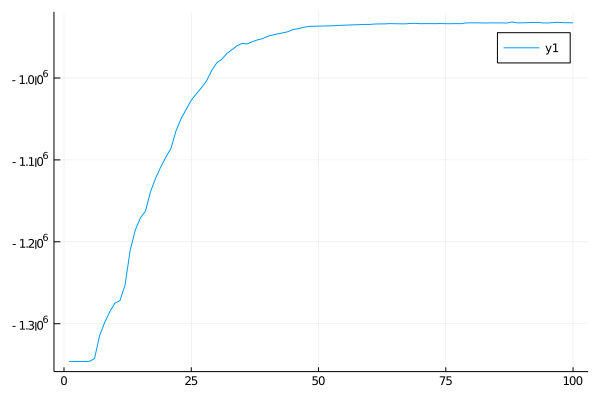

GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error


In [30]:
plot(bob,vhdpmm_results[3][1:150])